In [26]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import extcolors
import skimage
import scipy
from PIL import Image
import math
import skimage
from sklearn.linear_model import LinearRegression
import pandas as pd
from colormap import rgb2hex
import numpy as np
import cv2
import os


VID = 0
SING_IMG = 1
nb_row = 4

# READ AND NORMALIZE IMAGES
def obtain_name_images(image_folder):
    """
    input : name of the folder with the images
    output : name of the files to be open
    """
    lst = os.listdir(image_folder)
    lst.sort()
    name_images = [img for img in lst 
                if img.endswith(".jpg") or
                    img.endswith(".jpeg") or
                    img.endswith("png")]

    return name_images 

def obtain_images(name_images, image_folder, mode):
    """
    input : name and foler of the images location
    returns : list containing all the images in the folder in RGB format
    """
    imgs = []
    if mode == VID : 
        for name in name_images:
            img = cv2.imread(os.path.join(image_folder, name))
            if img is not None : 
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_small = img_resize(img_rgb)
                imgs.append(img_small)

    if mode == SING_IMG :
        print('image read : ', os.path.join(image_folder, name_images))
        img = cv2.imread(os.path.join(image_folder, name_images))
        if img is not None : 
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_small = img_resize(img_rgb)
            imgs.append(img_small)
        else : 
            print('no image read')

    if (len(imgs) != 0) : 
        return imgs #return rgb img
    
    return None


def img_resize(img, output_width = 320):
    """
    input : image
    output : resized image
    """
    wpercent = (output_width/float(img.shape[1]))
    hsize = int((float(img.shape[0])*float(wpercent)))
    img = cv2.resize(img, (output_width,hsize), interpolation = cv2.INTER_AREA) 
    #this resize makes the video not work??
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def colors_to_array(colors_x) : 
    """
    input : tuple containing list of the main colors cluster of the images
    output : 2 np array containg the cluster color in rgb and lab space
    """
    colors_rgb = np.zeros((len(colors_x[0]),3))
    colors_lab = np.zeros((len(colors_x[0]),3))

    for i in range(len(colors_x[0])):
        col = colors_x[0][i][0]
        colors_rgb[i] = col
        colors_lab[i] = skimage.color.rgb2lab((col[0]/255, col[1]/255, col[2]/255))

    return colors_rgb, colors_lab



def donuts(colors_x): 
    """
    input : tuple containing list of the main colors cluster of the images and their occurence
    output : plt figure reprensenting the main colors anf their proportions
    """
    colors_pre_list = str(colors_x).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df_color = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    list_color = list(df_color['c_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' 
            for c, p in zip  (list_color, list_precent)]
    fig, ax = plt.subplots(figsize=(50,50),dpi=10)
    wedges, text = ax.pie(list_precent,
                        labels= text_c,
                        labeldistance= 1.05,
                        colors = list_color,
                        textprops={'fontsize': 120, 'color':'black'}
                        )
    plt.setp(wedges, width=0.3)

    #create space in the center
    plt.setp(wedges, width=0.36)

    ax.set_aspect("equal")
    fig.set_facecolor('white')
    plt.show()  

def extract_rgb_colors(img):
    """
    input : rgb image as np array
    output : list of main rgb colors 
    """
    # extract the main colors from the image 
    im_pil = Image.fromarray(img)
    colors_x = extcolors.extract_from_image(im_pil, tolerance = 12, limit = 8) 
    colors_rgb, colors_lab = colors_to_array(colors_x)
    #donuts(colors_x)# for debugging 

    return colors_rgb

def greenest_color(colors_rgb):
    """
    input : list of rgb colors
    output : greenest color in rgb format
    """
    diff = smallest_diff = float('inf')

    for col in colors_rgb:
        # calculate the difference to the green
        diff = np.linalg.norm(np.asarray(col - [0,255,0])) # maybe better to use lab format?
        if diff < smallest_diff: # if closest to green
            smallest_diff =diff
            col_best_mask = col
    col_best_mask = col_best_mask.astype(int)
    r,g,b = (col_best_mask.data)
    
    print('the best color is : rgb ', col_best_mask, 'hex : ', rgb2hex(r,g,b))

    return col_best_mask

def mask_vegetation(img_lab, col_lab):
    """
    input : 
    output :
    """
    # Using inRange method, to create a mask
    thr = [8,8,8] #TODO : maybe change  thr according to histogram ??
    lower_col = col_lab - thr
    upper_col = col_lab + thr
    mask = cv2.inRange(img_lab, lower_col, upper_col)
    return mask

def veg_segmentation(img):

    # extract the main colors from the image 
    colors_rgb = extract_rgb_colors(img)

    # extract greenest color 
    col_best_mask = greenest_color(colors_rgb)

    # convert color and image to lab space
    img_lab = skimage.color.rgb2lab(img/255)
    col_best_mask_lab = skimage.color.rgb2lab((col_best_mask[0]/255, col_best_mask[1]/255, col_best_mask[2]/255))

    # vegetation segmentation using mask of the detected vegetal color
    best_mask = mask_vegetation(img_lab, col_best_mask_lab)
    best_mask_median = cv2.medianBlur(best_mask,3)
    
    return best_mask_median, col_best_mask


def hough_line_improved(mask, angle_acc):
    """
    input : 2D mask + list containing the angle previously found
    output : accumulator + array to convert theta and rhos to accumulator coordinates
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(0, 180))
    width, height = mask.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, num = diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(mask)  # (row, col) indexes to edges
    #print(y_idxs, x_idxs)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        #print('step ', i, 'of len ', len(x_idxs))
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1
            if (abs(np.rad2deg(thetas[t_idx])-90)<20): #if horizontale lignes 
                accumulator[:, t_idx] = 0
            
            for angle in angle_acc:
                if (abs(np.rad2deg(thetas[t_idx])-np.rad2deg(angle))<10): #if angle already detected 
                    accumulator[:, t_idx] = 0


    return accumulator, thetas, rhos

def keep_mask_max_acc_lines(best_mask_edge, img_no_sky, crop_nb):
    """
    input : mask where we want to use HT, img to draw on it, 
            nb_of crops we want to detect
    output : new mask for next image, list of theta and r detected, 
            threshold_acc, best_mask_evaluate = img with lines drawned
    """

    best_mask_edge_copy = np.copy(best_mask_edge)
    best_mask_evaluate = np.copy(img_no_sky)
    img_no_sky_copy = np.copy(img_no_sky)

    #crop_nb = 3

    th_acc = []
    r_acc = []
    threshold_acc = []
    mask = []

    for i in range(crop_nb):
        mask_single_crop = np.zeros_like(best_mask_edge)

        print('step ', (i+1), 'of ', crop_nb)
        acc, thetas, rhos = hough_line_improved(best_mask_edge_copy, th_acc)

        th_max = acc.max()

        r_idx, th_idx = np.where(acc>=th_max)
        r = rhos[r_idx[0]]#in case multiple same max 
        th = thetas[th_idx[0]]

        th_acc.append(th)
        r_acc.append(r)
        threshold_acc.append(th_max)

        a = math.cos(th)
        b = math.sin(th)
        x0 = a * r
        y0 = b * r
        p1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        p2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

        cv2.line(best_mask_edge_copy, p1, p2, (0,0,0), 30)
        cv2.line(best_mask_evaluate, p1, p2, (255,0,0), 3)
        cv2.line(img_no_sky_copy, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), 50)
        mask.append(mask_single_crop)

    return mask, th_acc, r_acc, threshold_acc, best_mask_evaluate

def VP_detection(th_acc, r_acc, threshold_acc,img_no_sky_copy ): 
    #VP detection 
    #ADD COND THAT INTERSEECTON MUST BE IN A RADIUS TO AVOID OUTLIERS 
    # => or KMEAN with K = 2?

    A = B = C = D = E = 0

    for t,r,w in zip(th_acc, r_acc, threshold_acc):
        a = np.cos(t)
        b = np.sin(t)
        A = A + w*pow(a,2)
        B = B + w*pow(b,2)
        C = C + w*a*b
        D = D + w*a*r
        E = E + w*b*r

    M = np.array([[A,C],[C,B]])
    #print(np.linalg.det(M))
    b = np.array([D,E])
    x0,y0 = np.linalg.solve(M,b).astype(int)

    cv2.circle(img_no_sky_copy, (x0, y0), 10, (255,255,255), 5)
    #cv2.imshow('VP drawned : ', img_no_sky_copy)
    #cv2.waitKey(1000)

    print('VP is : ', x0, y0)

    return x0,y0


def apply_ransac(img_no_sky, masked_images_i, vp_point, vp_on):

    mask_single_crop = np.zeros_like(img_no_sky)
    x,y = np.where(masked_images_i>0)
    data = np.column_stack([x, y])
    if(vp_on>0):
        vp_point = np.asarray(vp_point)
        n = int(data.shape[0])
        vp_data_x = np.full((n,1), vp_point[1])
        vp_data_y = np.full((n,1), vp_point[0])
        data_vp = np.column_stack([vp_data_x, vp_data_y])
        data = np.row_stack([data, data_vp])

    #print('data : ', data.size)
    #if (data.size<10):
        #cv2.waitKey(20000)
    if (1) : #(data.shape>10):
        model, inliers = skimage.measure.ransac(data, skimage.measure.LineModelND, min_samples=2,
                                    residual_threshold=1, max_trials=100)
        temp = np.copy(masked_images_i)
        y0, x0 = model.params[0]#.astype(int)
        t1, t0 = model.params[1]
        m = t1/t0
        #print(m)
        #ADD CONDITION ON M
        x2 = (x0 + 500)
        y2 = (y0 + 500*m)
        x1 = (x0 - 500)
        y1 = (y0 - 500*m)
        p1 = [int(x1),int(y1)]
        p2 = [int(x2),int(y2)]
    else : 
        p1 = [0,0]
        p2 = [0, 1]
        m  = 0
    return p1, p2, m


def remove_double(p1, p2, m, acc_m, masked_image):
    cond_double = 0
    #print('in')
    #print(acc_m)
    if (len(acc_m)>=1):
        for m_others in acc_m:
            if (abs(m-m_others)<0.1): #if angle already detected 
                #print('diff m', m - m_others)

                cv2.line(masked_image, p1, p2, (0,0,0), 15)
                cond_double = 0
                #print('diff : ', m, m_others)
            
            else : #pas une bonne idée : une crop pourrait en remplacer une autre 
                cond_double = 1
    else : 
        cond_double = 1

    return masked_image, cond_double

def remove_horizon(p1, p2, m, masked_image):
    thr = 0.1
    cond_horizon = 0

    if (abs(m)<thr):
        cv2.line(masked_image, p1, p2, (0,0,0), 15)
        #print('horizon detected', m)

    if (abs(m)>=thr):
        cond_horizon = 1

    return masked_image, cond_horizon


def squared_distance_to_line(point, line_point1, line_point2):
    # Convert the points to numpy arrays for easier calculations
    point = np.array(point)
    line_point1 = np.array(line_point1)
    line_point2 = np.array(line_point2)

    # Calculate the direction vector of the line
    line_dir = line_point2 - line_point1

    # Calculate the normal vector of the line
    line_normal = np.array([line_dir[1], -line_dir[0]])

    # Calculate the squared distance from the point to the line by taking the dot product of the normal vector
    # with the vector pointing from the line to the point, and then dividing by the square of the length of the normal vector
    return np.dot(line_normal, point - line_point1)**2 / np.dot(line_normal, line_normal)


def pattern_ransac_old(arr_mask, vp_point, img, max_iterations=50, threshold=100):

    model = None 
    nb_cr = len(arr_mask)
    data = np.zeros(((nb_cr+1),2)) #+1 for the VP point 
    best_nb_inliers = 0

    for it in range(max_iterations):
        if (it%10==0):
            print('iteration ', it, ' out of ', max_iterations)
        
        list_cr_lines = []

        rand_vp = [vp_point[0] + np.random.randint(-20,20), vp_point[1] + np.random.randint(-20, 20)]

        #first randomly select data 
        data[nb_cr] = rand_vp
        for i in range(nb_cr): #select randomlw one point from each mask

            row = cv2.bitwise_and(img, arr_mask[i])
            y,x = np.where(row>0)
            rand_nb = np.random.randint(0, len(x)-1)
            data[i] = [x[rand_nb], y[rand_nb]]
            pt1 = (rand_vp[0], rand_vp[1])
            pt2 = (x[rand_nb], y[rand_nb])
            list_cr_lines.append([pt1, pt2])

        nb_inliers = 0

        
        #calculate error 
        for i in range(nb_cr):
            row = cv2.bitwise_and(img, arr_mask[i])
            x,y = np.where(row>0)
            [p1,p2] = np.array(list_cr_lines[i])

            for x_x, y_y in zip(x,y):
                p3 = np.array(x_x,y_y)
                err = squared_distance_to_line(p3, p1, p2)
                #print(err)

                if abs(err)<threshold:
                    nb_inliers = nb_inliers + 1
        

        if nb_inliers>best_nb_inliers:
            best_nb_inliers = nb_inliers
            model = list_cr_lines
            print('new best nb inlier : ', nb_inliers, 'model : ', model)

    
    print(model)
    return model

In [27]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import extcolors
import skimage
import scipy
from PIL import Image
import math
import skimage
from sklearn.linear_model import LinearRegression
import pandas as pd
from colormap import rgb2hex
import numpy as np
import cv2
import os
import MaskingProcess


def Initial_Process(img, nb_row = 4, sky_on = 0):

    best_mask_median, col_best_mask = veg_segmentation(img)
    best_mask_median_edge = cv2.Canny(best_mask_median,100,200)

    arr_mask, th_acc, r_acc, threshold_acc, best_mask_evaluate = keep_mask_max_acc_lines(best_mask_median_edge, img, nb_row)
    #print(th_acc, r_acc)
    #th_acc_order = th_acc.sort

    vp_pt = np.asarray(VP_detection(th_acc, r_acc, threshold_acc, best_mask_median_edge))

    return best_mask_evaluate, arr_mask, col_best_mask, vp_pt, best_mask_median





In [28]:
mode = SING_IMG
VID = 0
SING_IMG = 1
INI_PROCESS = 0
SPEED_PROCESS = 1
FINAL_PROCESS = 2

if __name__ == "__main__":

    #first, get the name of the files we are going to analyze
    if (mode == VID):
        #distinguer entre mode video et mode single image?
        imgs_folder = '/home/roxane/Desktop/M3_2022/USB/Realsense_18-08-2022_10-46-58/'
        name_images = obtain_name_images(imgs_folder)

    if (mode == SING_IMG): 
        print('sing img')
        imgs_folder = '/home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines'
        name_images = 'crop_row_023.JPG'

#open and resize images for consistency --> returns img in rgb format
images = obtain_images(name_images,imgs_folder, mode)


sing img
image read :  /home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines/crop_row_023.JPG


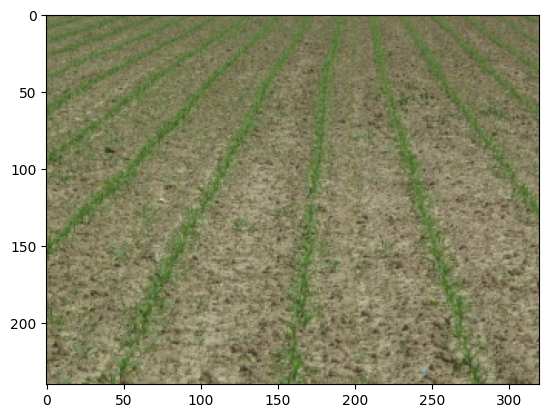

In [29]:
img = images[0]
plt.imshow(images[0])

In [30]:
imgs_annotated = []
stage = INI_PROCESS

if stage == INI_PROCESS: #longer but needed to create initial mask of images 
    print('initial process...')
    hough_img, arr_mask, col_best_mask, vp_pt, best_mask_median = Initial_Process(images[0], nb_row=6)
    stage = SPEED_PROCESS

initial process...
the best color is : rgb  [ 75 103  42] hex :  #4B672A
step  1 of  6
step  2 of  6
step  3 of  6
step  4 of  6
step  5 of  6
step  6 of  6
VP is :  193 -42


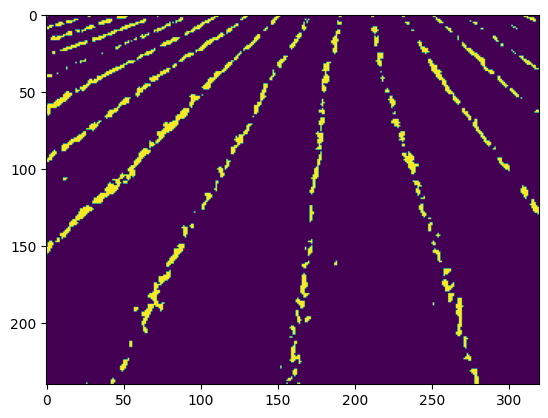

In [31]:
plt.imshow(best_mask_median)

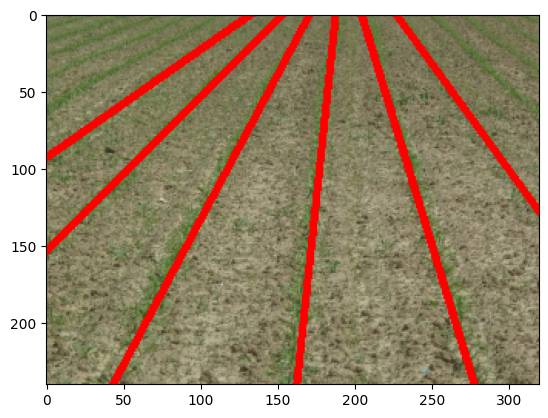

In [32]:
plt.imshow(hough_img)

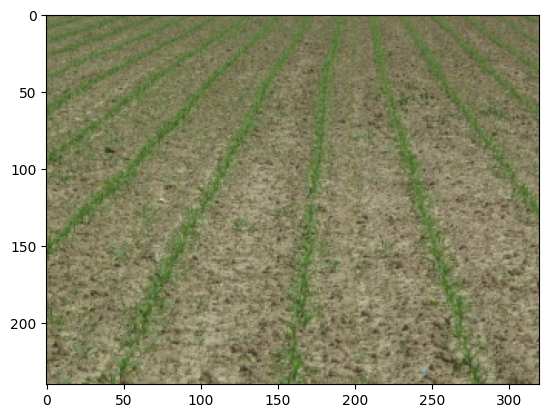

In [33]:
plt.imshow(images[0])

In [34]:
#def check_model(img_best_median, arr_mask, model):
    

In [35]:
def pattern_ransac(arr_mask, vp_point, img, max_iterations=50, threshold=100):

    model = None 
    nb_cr = len(arr_mask)
    data = np.zeros(((nb_cr+1),2)) #+1 for the VP point 
    best_nb_inliers = 0

    for it in range(max_iterations):
        if (it%10==0):
            print('iteration ', it, ' out of ', max_iterations)
        
        list_cr_lines = []

        rand_vp = [vp_point[0] + np.random.randint(-20,20), vp_point[1] + np.random.randint(-20, 20)]
        nb_inliers = 0


        #first randomly select data 
        data[nb_cr] = rand_vp
        for i in range(nb_cr): #select randomlw one point from each mask
            row = cv2.bitwise_and(img, arr_mask[i])
            if (i==5): 
                #nameinstring = "mask {} ".format(i)
                #cv2.imshow(nameinstring, row)
                #cv2.waitKey(1000)
                plt.imshow(row)
                
            y,x = np.where(row>0)
            rand_nb = np.random.randint(0, len(x)-1)
            data[i] = [x[rand_nb], y[rand_nb]]
            pt1 = (rand_vp[0], rand_vp[1])
            pt2 = (x[rand_nb], y[rand_nb])
            list_cr_lines.append([pt1, pt2])
            [p1,p2] = np.array(list_cr_lines[i])

            for x_x, y_y in zip(x,y):
                p3 = np.array(x_x,y_y)
                err = squared_distance_to_line(p3, p1, p2)
                #print(err)

                if abs(err)<threshold:
                    nb_inliers = nb_inliers + 1
        

        if nb_inliers>best_nb_inliers:
            best_nb_inliers = nb_inliers
            model = list_cr_lines
            print('new best nb inlier : ', nb_inliers, 'model : ', model)

    
    print(model)
    return model

In [36]:
def Speed_Process(img, arr_mask, col_best_mask, vp_pt, sky_on = 0, nb_row = 4):

    annotated_img = np.copy(img)
    img_lab = skimage.color.rgb2lab(img/255)

    col_best_mask_lab = skimage.color.rgb2lab((col_best_mask[0]/255, col_best_mask[1]/255, col_best_mask[2]/255))
    
    # vegetation segmentation using mask of the detected vegetal color
    best_mask = MaskingProcess.mask_vegetation(img_lab, col_best_mask_lab)
    best_mask_median = cv2.medianBlur(best_mask,3)

    #cv2.imshow('best_mask_median', best_mask_median)
    #cv2.waitKey(1000)

    print(best_mask_median.shape)
    model = pattern_ransac(arr_mask, vp_pt, best_mask_median, max_iterations=1) 


    for crop in model:
        crop = np.asarray(crop)
        diff = (crop[1]-crop[0])
        cv2.line(annotated_img, crop[0], crop[1]+5*diff, (50,200,50), 3)


    #cv2.line(annotated_img, (10,100), (100,10), (255,0,0), 10)
    #cv2.line(annotated_img, (100,10), (10,100), (0,255,0), 5)
    #cv2.line(annotated_img, (10,10), (100,100), (0,0,255), 2)

    #TODO : improve the array mask 

    return annotated_img, arr_mask, model

(240, 320)
iteration  0  out of  1
new best nb inlier :  316 model :  [[(181, -38), (111, 40)], [(181, -38), (255, 154)], [(181, -38), (184, 31)], [(181, -38), (126, 79)], [(181, -38), (30, 73)], [(181, -38), (266, 55)]]
[[(181, -38), (111, 40)], [(181, -38), (255, 154)], [(181, -38), (184, 31)], [(181, -38), (126, 79)], [(181, -38), (30, 73)], [(181, -38), (266, 55)]]


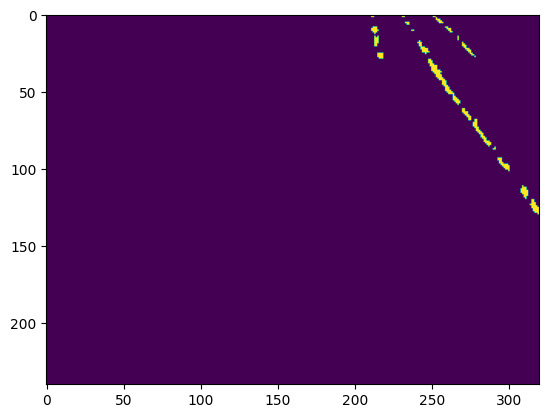

In [37]:
img = images[0]
img_annotated, arr_mask, model = Speed_Process(img, arr_mask, col_best_mask, vp_pt)

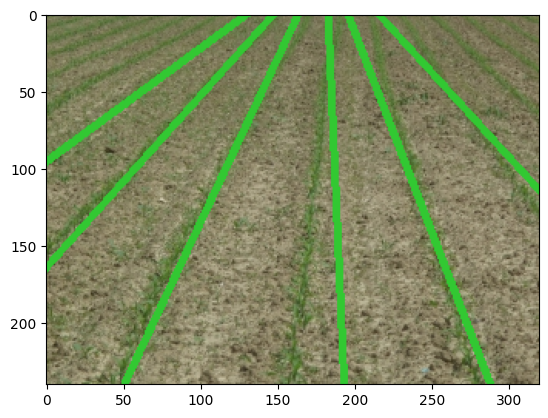

In [38]:
plt.imshow(img_annotated)

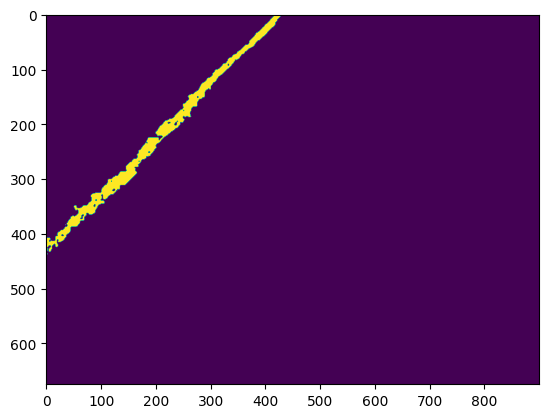

In [15]:
temp = np.copy(best_mask_median)
plt.imshow(cv2.bitwise_and(temp, arr_mask[0]))

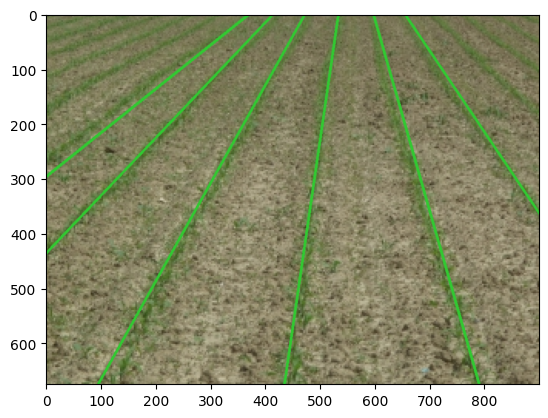

In [16]:
plt.imshow(img_annotated)